# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 27, 2023 at 11:59pm**

## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has cancer or not. It is important to catch this disease early to reduce mortality rate; late diagnosis will result in metastasis to other organs, which adversely impacts patient's prognosis. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|         | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 48 | 32 |
| **Actual no disease**       | 20 | 100 |


- Model B

|        | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 43 | 22 |
| **Actual no disease**       | 35 | 100 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

The positive class is the result class that the problem cares the most, in this case, the problem is whether a patient has cancer or not and  having the disease is the more important and demanding result. So the positive class is disease.

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
results_dict["A"]["accuracy"] = (48 + 100)/(48 + 100 + 32 + 20)
results_dict["B"]["accuracy"] = (43 + 100)/(43 + 100 + 35 + 22)
print(results_dict["A"]["accuracy"])
print(results_dict["B"]["accuracy"])

0.74
0.715


<br><br>

### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

Model A since it has a higher accuracy.

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [4]:
results_dict["A"]["precision"] = 48/68
results_dict["B"]["precision"] = 43/78
results_dict["A"]["recall"] = 48/80
results_dict["B"]["recall"] = 43/65
results_dict["A"]["f1"] = 2*results_dict["A"]["precision"]*results_dict["A"]["recall"]/(results_dict["A"]["precision"]+results_dict["A"]["recall"])
results_dict["B"]["f1"] = 2*results_dict["B"]["precision"]*results_dict["B"]["recall"]/(results_dict["B"]["precision"]+results_dict["B"]["recall"])

Show the dataframe with all results. 

In [5]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.740000,0.715000
precision,0.705882,0.551282
recall,0.600000,0.661538
f1,0.648649,0.601399


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Given the type of problem (early cancer diagnosis), which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

1. Since this probelm is about Spotting the postivtive class and the FN is more damaging to this problem, so recall which takes account the FN value is more informative in this problem.
2. Model B.

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
Since the dataset is highly imbalance with fraudulent credit card transactions only account the 0.172% of all transactions. The accuracy metric would be misleading since it would be dominated by the predictions of negative classes. Recall would be more appropriated because based on the context "It is important that credit card companies are able to recognize fraudulent credit card transactions".

https://www.kaggle.com/datasets/mathchi/diabetes-data-set
Since "The objective is to predict based on diagnostic measurements whether a patient has diabetes", the diagnosis diabetes is more important to this problem, thus accuracy metric would be misleading and f1 metrics is more appropriate at evaluating the model overall in respect to the positive class.


<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [6]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [7]:
print(train_df.shape[0])
train_df[(train_df["churn"] == True)].shape[0]

2333


349

Yes. We do not need to deal with it at this stage since we cannot re collect the data, plus the imbalance is the nature of 

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 
rubric={points:14}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

For each group of features (e.g. numeric, categorical or else) explain why you are applying the particular transformation. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Finally, fit `ColumnTransformer` on your training set; and use the `ColumnTransformer` to transform your train data.

In [8]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [9]:
#citation: https://canvas.ubc.ca/courses/106375/files/folder/Homework%20solutions
# X_train.info()

In [10]:
# I am doing transformation Scaling to the numeric_features features because scaling 
# all features with different ranges can avoid the features with smaller values being ignored
numeric_features = ['account length', 'area code', 'number vmail messages', 'total day minutes',
                    'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 
                    'total eve charge', 'total night minutes', 'total night calls', 'total night charge',
                    'total intl minutes', 'total intl calls', 'customer service calls']
# I am doing transformation OneHotEncoder to the feature 'state' because it is a categorical 
# feature and each category of the feature is independent from another, thus new new binary columns 
# need to be created to represent those categories
# I am doing transformation OneHotEncoder to the feature 'area code' because even though the values 
# are in int64 but indeed one integer represents one area(a category), thus new new binary columns 
# need to be created to represent those categories 
categorical_features = ['state', 'area code']
# I am doing transformation OneHotEncoder to the binary_features features because these features 
# only have binary categories "yes" and "no"
binary_features = ['international plan', 'voice mail plan']
# I am dropping feature 'phone number because it does not provide useful characteristic to predict
# the target
drop_features = ['phone number']

In [11]:
numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor_2_3 = make_column_transformer(
    (numeric_transformer, numeric_features),   
    (binary_transformer, binary_features),    
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)
transformed_2_3 = preprocessor_2_3.fit_transform(X_train, y_train)

In [12]:
column_names_2_3 = (
    numeric_features
    + preprocessor_2_3.named_transformers_["pipeline-2"].get_feature_names_out().tolist()
    + preprocessor_2_3.named_transformers_["pipeline-3"].get_feature_names_out().tolist()
)
pd.DataFrame(transformed_2_3, columns=column_names_2_3)

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area code_408,area code_415,area code_510
0,-0.767893,-0.509593,-0.587624,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.843585,1.760678,-0.587624,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.544113,-0.509593,1.900976,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.165650,1.760678,-0.587624,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.115188,1.760678,-0.587624,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.645037,-0.676876,-0.587624,0.329045,1.259175,0.328771,0.898602,0.612316,0.897957,1.652771,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2329,-0.767893,1.760678,1.608200,-0.664820,-1.414346,-0.664665,-0.618094,-0.398570,-0.618157,-1.440956,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2330,0.619806,-0.509593,-0.587624,0.048489,-1.810423,0.048322,-1.216842,1.067214,-1.217606,-0.582024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2331,1.477656,-0.509593,-0.587624,0.173180,0.219472,0.173445,0.890672,2.381365,0.890960,0.801701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<br><br>

<br><br>

### 2.4 area code feature
rubric={points:4}

The original dataset had a feature called `area code`.

1. The area codes are numbers. Does it make sense to encode them as one-hot-endoded (OHE) or not? Please justify your response.
2. What were the possible values of `area code`? 
3. If area code is encoded with OHE, how many new features are created to replace it?

In [13]:
train_df["area code"].unique()

array([415, 510, 408])

1. Even though the values are numbers but indeed each number represents one area which is a category. So it make sense to encode them as OHE.
2. 415, 510, 408
3. Three.

<br><br>

### 2.5 Logistic regression
rubric={points:12} 

**Your tasks:**

1. Report the cross-validation results of a `LogisticRegression` model, with default Hparams, on the following metrics: `"accuracy", "precision", "recall", "f1"`
2. Are you satisfied with the results? Explain why or why not. Discuss in a few sentences. 

In [14]:
#citation: cpsc330 lecture 9
scoring = [
    "accuracy",
    "precision",
    "recall",
    "f1",
]  
pipe_2_5 = make_pipeline(preprocessor_2_3, LogisticRegression())
pipe_2_5.fit(X_train, y_train)
scores = cross_validate(
    pipe_2_5, X_train, y_train, return_train_score=False, scoring=scoring
)
pd.DataFrame(scores).mean()

fit_time          0.039615
score_time        0.005189
test_accuracy     0.855978
test_precision    0.548663
test_recall       0.209317
test_f1           0.302739
dtype: float64

1. "accuracy": 0.855978
    "precision": 0.548663
    "recall": 0.209317
    "f1": 0.302739
2. No, the high accuracy score is due to the fact that this is an imbalanced data set where most 
target feature have churn=False.
But we can tell from the recall that only 20% of real positives had been predicted correctly; and only 55% are real positives among all positive predictions.
Overall, the model is not good at predicting TPs.

<br><br>

### 2.6 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences while comparing the metrics of this model and the previous model.

In [15]:
pipe_2_6 = make_pipeline(
    preprocessor_2_3, LogisticRegression(class_weight="balanced")
)
pipe_2_6.fit(X_train, y_train)
scores_2_6 = cross_validate(
    pipe_2_6, X_train, y_train, return_train_score=False, scoring=scoring
)
pd.DataFrame(scores_2_6).mean()

fit_time          0.044215
score_time        0.005483
test_accuracy     0.760379
test_precision    0.350255
test_recall       0.696356
test_f1           0.465596
dtype: float64

1. "accuracy": 0.760379 "precision": 0.350255 "recall": 0.696356 "f1": 0.465596
2. Both the accuracy and precision had decreased in this model. The recall metrics is much higher than the previous model where 70% of real positives had been predicted correctly among all real positives. 
Yes, I prefer this model. Since goal is to capture the customer churn, thus more real positive are captured the better. So the model with high recall is more preferable. ?????f1 since both class is important?????

<br><br>

### 2.7 Hyperparameter optimization
rubric={points:10}

1. Jointly optimize `C` and `class_weight` with `GridSearchCV` and `scoring="f1"`.
  - For `class_weight`, consider 3 values: 
    - `None` (no weight)
    - "weight of class 0 = 1"  and  "weight of class 1 = 3"
    - '`balanced`'
  - For `C`, choose some reasonable values
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [16]:
#citation: lecture 8
pipe_2_7 = make_pipeline(preprocessor_2_3, LogisticRegression(max_iter=1000))

param_grid_2_7 = {
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "logisticregression__class_weight": [None, {0:1, 1: 10}, {0:1, 1: 100}, {0:1, 1: 1000}, {0:1, 1: 10000}, "balanced"],
}
grid_search_2_7 = GridSearchCV(
    pipe_2_7, param_grid_2_7, scoring="f1", return_train_score=False
)
grid_search_2_7.fit(X_train, y_train)
print(grid_search_2_7.best_score_)
print(grid_search_2_7.best_params_)

0.47873599874436196
{'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced'}


2. choose C=0.1 and class_weight='balanced'. The best f1 score is 0.47873599874436196


<br><br>

### 2.8 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Plot Confusion matrix
    - Plot Precision-recall curve 
    - Calculate average precision score
    - Plot ROC curve
    - Report AUC score
3. Comment on the AUC score and give an intuitive explanation of what this value of AUC means for this problem.

In [17]:
pipe_2_8 = make_pipeline(preprocessor_2_3, LogisticRegression(max_iter=1000, C=0.1, class_weight='balanced'))
pipe_2_8.fit(X_train, y_train)
predictions_2_8 = pipe_2_8.predict(X_test)

Confusion matrix for fraud data set


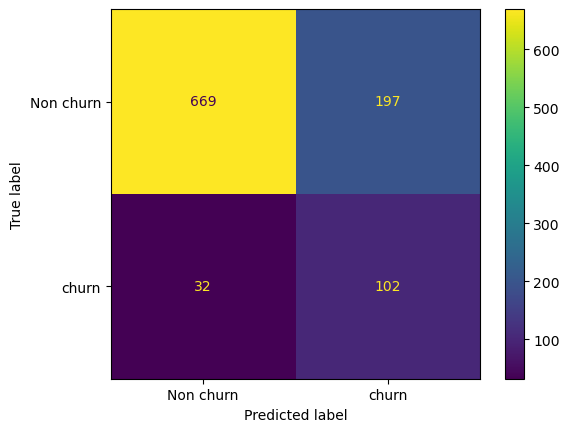

In [18]:
#citation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# lecture 9
from sklearn.metrics import ConfusionMatrixDisplay
cm_2_8 = confusion_matrix(y_test, predictions_2_8)
print("Confusion matrix for fraud data set")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2_8, display_labels=["Non churn", "churn"])
disp.plot()
plt.show()

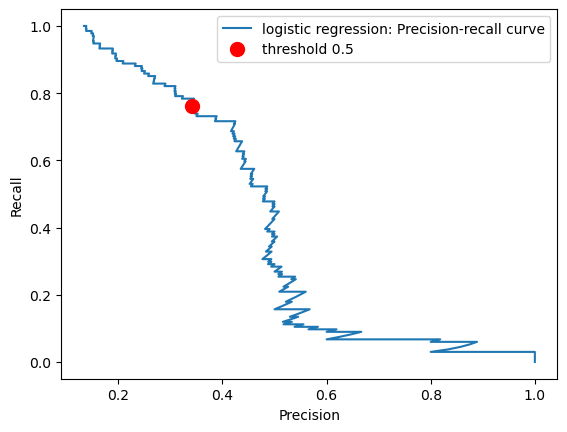

In [19]:
from sklearn.metrics import precision_recall_curve
precision_2_8, recall_2_8, thresholds_2_8 = precision_recall_curve(
    y_test, pipe_2_8.predict_proba(X_test)[:, 1]
)
plt.plot(precision_2_8, recall_2_8, label="logistic regression: Precision-recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_test, pipe_2_8.predict(X_test)),
    recall_score(y_test, pipe_2_8.predict(X_test)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [20]:
from sklearn.metrics import average_precision_score

ap_2_8 = average_precision_score(y_test, pipe_2_8.predict_proba(X_test)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_2_8))

Average precision of logistic regression: 0.456


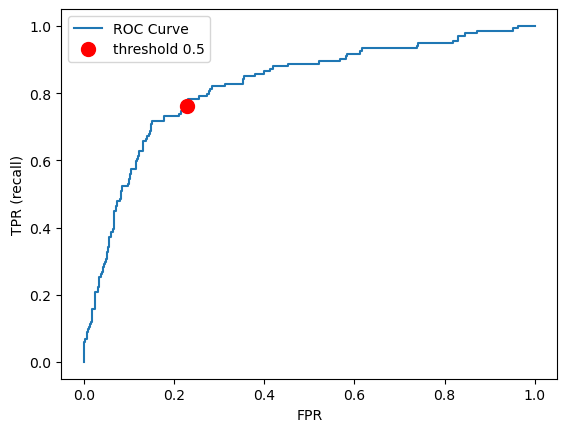

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, pipe_2_8.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

In [22]:
from sklearn.metrics import roc_auc_score

roc_2_8 = roc_auc_score(y_test, pipe_2_8.predict_proba(X_test)[:, 1])
print("AUC for logistic regression: {:.3f}".format(roc_2_8))

AUC for logistic regression: 0.823


2. AUC score is the value of area under the ROC curve. It is the sum of all recall values at every FPR value(the predicted probability of that example belongs to the negative class).
AUC = 0.823: The probability that a randomly picked an instance with churn = True has a higher score according to the classifier than a randomly picked an instance with churn = False is 0.823. 

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [23]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (75%) and test (25%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` to train and test splits. 

In [24]:
housing_train_df, housing_test_df = train_test_split(housing_df, test_size=0.25, random_state=123)
print(housing_train_df.shape)
print(housing_train_df.info())
housing_train_df

(15480, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 19995 to 19966
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       15480 non-null  float64
 1   HouseAge     15480 non-null  float64
 2   AveRooms     15480 non-null  float64
 3   AveBedrms    15480 non-null  float64
 4   Population   15480 non-null  float64
 5   AveOccup     15480 non-null  float64
 6   Latitude     15480 non-null  float64
 7   Longitude    15480 non-null  float64
 8   MedHouseVal  15480 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
19995,1.0349,6.0,4.165217,0.982609,734.0,3.191304,36.19,-119.35,0.678
17889,4.7625,13.0,5.265207,1.002433,1087.0,2.644769,37.41,-121.95,1.375
1977,3.5192,9.0,8.747475,1.845118,796.0,2.680135,38.61,-120.44,0.980
6861,2.8672,30.0,4.635616,1.090411,1130.0,3.095890,34.06,-118.13,1.985
11247,4.1276,13.0,4.429936,0.963376,1749.0,2.785032,33.81,-118.00,1.538
...,...,...,...,...,...,...,...,...,...
7763,3.6389,36.0,5.584615,1.115385,490.0,3.769231,33.91,-118.10,1.676
15377,4.5391,14.0,6.016688,1.017972,2436.0,3.127086,33.37,-117.24,1.809
17730,5.6306,5.0,5.958393,1.031564,2435.0,3.493544,37.33,-121.76,2.862
15725,3.8750,44.0,4.739264,1.024540,561.0,1.720859,37.78,-122.44,4.125


In [25]:
#2. Scaling to all the features are needed
numeric_features_3_1 = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude']
preprocessor_3_1 = make_column_transformer(
    (numeric_transformer, numeric_features_3_1),   
)

In [26]:
#3
housing_X_train = housing_train_df.drop(columns=["MedHouseVal"])
housing_X_test = housing_test_df.drop(columns=["MedHouseVal"])

housing_y_train = housing_train_df["MedHouseVal"]
housing_y_test = housing_test_df["MedHouseVal"]

<br><br>

### 3.2 Baseline: Linear Regression 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `sklearn.linear_model.LinearRegression` with default scoring. 
2. What metric is used for scoring by default? 

In [27]:
#citation: lecture 10 and lecture 5
from sklearn.linear_model import LinearRegression

pipe_3_2 = make_pipeline(preprocessor_3_1, LinearRegression())
scores_3_2 = cross_val_score(pipe_3_2, housing_X_train, housing_y_train)
pd.DataFrame(scores_3_2)

,0
0,0.608602
1,0.599240
2,0.616816
3,0.592949
4,0.015128


2. $R^2$ is used by defualt by LinearRegression.

<br><br>

### 3.3 Random Forest Regressor
rubric={points:7}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for two model (`models`) and five evaluation metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [28]:
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

In [29]:
for model in models.values():
    pipe_3_3 = make_pipeline(preprocessor_3_1, model)
    scores_3_3 = cross_validate(pipe_3_3, housing_X_train, housing_y_train, scoring = score_types_reg)
    display(pd.DataFrame(scores_3_3))

,fit_time,score_time,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_error,test_r2,test_neg_mean_absolute_percentage_error
0,0.005483,0.002136,-0.549963,-0.741595,-0.539838,0.608633,-0.321621
1,0.004033,0.003366,-0.539582,-0.734563,-0.544145,0.599232,-0.319187
2,0.003958,0.002080,-0.509989,-0.714135,-0.522755,0.616812,-0.313360
3,0.003913,0.002436,-0.538532,-0.733847,-0.536827,0.592940,-0.322003
4,0.003527,0.001777,-1.255748,-1.120602,-0.536979,0.014994,-0.320155


,fit_time,score_time,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_error,test_r2,test_neg_mean_absolute_percentage_error
0,6.144675,0.062753,-0.261793,-0.511657,-0.339003,0.813702,-0.196905
1,6.131603,0.061286,-0.274607,-0.524029,-0.339603,0.796039,-0.184491
2,6.076734,0.061368,-0.251702,-0.501699,-0.329315,0.810880,-0.186291
3,6.044387,0.059108,-0.286120,-0.534902,-0.347603,0.783730,-0.196578
4,6.039924,0.058909,-0.267356,-0.517065,-0.335348,0.790287,-0.190411


3. The metrics of Ridge model are highly identical to the baseline model but has faster fit time. The Random Forest model has fit time and score time much slower than the baseline, but all its metrics are higher than the baseline. Here all the metrics are negative values except for r2, meaning that the higher these metrics better. Thus, the Random Forest model have smaller errors than the baseline, hence it has better predictions.

In [30]:
# Baseline model
pipe_3_3_baseline = make_pipeline(preprocessor_3_1, LinearRegression())
scores_3_3_baseline = cross_validate(pipe_3_3_baseline, housing_X_train, housing_y_train, scoring = score_types_reg)
pd.DataFrame(scores_3_3_baseline)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_root_mean_squared_error,test_neg_mean_absolute_error,test_r2,test_neg_mean_absolute_percentage_error
0,0.017586,0.002957,-0.550005,-0.741624,-0.539838,0.608602,-0.321621
1,0.016508,0.002434,-0.539571,-0.734555,-0.544146,0.599240,-0.319198
2,0.016769,0.002264,-0.509984,-0.714132,-0.522756,0.616816,-0.313362
3,0.015927,0.002440,-0.538520,-0.733839,-0.536830,0.592949,-0.322015
4,0.016604,0.002057,-1.255578,-1.120526,-0.536993,0.015128,-0.320178


<br><br>

### 3.4 Hyperparameter optimization 
rubric={points:1}

1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose `neg_mean_absolute_percentage_error` as the HParam optimization metric.

2. What was the best `alpha` hyper-parameter found?

In [31]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

In [32]:
#citation: lecture 8
score_types_reg_3_4 = {
    "neg_mean_absolute_error": "neg_mean_absolute_error",
}

pipe_3_4 = make_pipeline(preprocessor_3_1, Ridge())
random_search_3_4 = RandomizedSearchCV(
    pipe_3_4, param_distributions=param_dist, random_state=123, scoring = score_types_reg_3_4,
    refit=False
)
random_search_3_4.fit(housing_X_train, housing_y_train);

pd.DataFrame(random_search_3_4.cv_results_)[
    [
        "param_ridge__alpha",
        "split0_test_neg_mean_absolute_error",
        "split1_test_neg_mean_absolute_error",
        "split2_test_neg_mean_absolute_error",
        "split3_test_neg_mean_absolute_error",
        "split4_test_neg_mean_absolute_error",
        "mean_test_neg_mean_absolute_error",
        "rank_test_neg_mean_absolute_error"
    ]
].set_index("rank_test_neg_mean_absolute_error").sort_index().T

rank_test_neg_mean_absolute_error,1,2,3,4,5,6,7,8,9,10
param_ridge__alpha,15.094374,12.852228,20.740242,2.031836,0.768407,0.345652,0.225271,0.0521,0.022967,766.628906
split0_test_neg_mean_absolute_error,-0.539861,-0.539855,-0.539881,-0.539839,-0.539838,-0.539838,-0.539838,-0.539838,-0.539838,-0.558719
split1_test_neg_mean_absolute_error,-0.544168,-0.544159,-0.544191,-0.544143,-0.544145,-0.544146,-0.544146,-0.544146,-0.544146,-0.562497
split2_test_neg_mean_absolute_error,-0.522768,-0.522764,-0.522786,-0.522755,-0.522755,-0.522755,-0.522755,-0.522755,-0.522756,-0.542276
split3_test_neg_mean_absolute_error,-0.536794,-0.536797,-0.536797,-0.536824,-0.536828,-0.536829,-0.536829,-0.53683,-0.53683,-0.554985
split4_test_neg_mean_absolute_error,-0.53682,-0.536844,-0.536769,-0.536966,-0.536983,-0.536988,-0.53699,-0.536992,-0.536992,-0.550372
mean_test_neg_mean_absolute_error,-0.536082,-0.536084,-0.536085,-0.536106,-0.53611,-0.536111,-0.536112,-0.536112,-0.536112,-0.55377


2. The best alpha is 15.094374

<br><br>

### 3.5 Test results
rubric={points:4}

**Your tasks:**

Test the best model (from 3.4) on the test set based on the `neg_mean_absolute_percentage_error` score.

In [33]:
#citation: lecture 8 and 10
score_types_reg_3_5 = {
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

pipe_3_5 = make_pipeline(preprocessor_3_1, Ridge(alpha=15.094374))
scores_3_5 = cross_validate(pipe_3_5, housing_X_test, housing_y_test, scoring=score_types_reg_3_5)
pd.DataFrame(scores_3_5)

,fit_time,score_time,test_neg_mean_absolute_percentage_error
0,0.003983,0.001356,-0.298016
1,0.002920,0.001231,-0.401263
2,0.002933,0.001270,-0.316059
3,0.002905,0.001456,-0.317174
4,0.002794,0.001265,-0.339503


<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Explore coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: 
   - features 
   - coefficients
2. Increasing which feature values would result in higher housing price? 

In [43]:
pipe_3_5["ridge"].fit(housing_X_train, housing_y_train)
pipe_3_5["ridge"].feature_

AttributeError: 'Ridge' object has no attribute 'feature_'

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 